# Usage guide
Copyright: Donghu Guo

Author: Donghu Guo

Description: This is the notebook showing the workflow of how to implement 4D-Var data assimilation. See the table of contents for a clearer understanding of the structure of this notebook.

Github Repository: https://github.com/ese-msc-2021/irp-dg321

In [ ]:
import os
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Common imports
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib

In [3]:
sys.path.append("..")
# from tools import Data_preprocessing as t
import tools as t

## Set values

In [4]:
root_path = '..data/' # set the root path where data is stored
nNodes = 192060
ntimes = 9  # consecutive times for the AAE
step = 1  # step between times
BATCH_SIZE = 32
ncoeffs = 550

epochs = 10000

## Load pod coefficients-Train

In [ ]:
# PCA model
pca_compress = joblib.load(root_path + 'Cotrace_fixed_720_npys/train_pca_compress.pkl')
# POD coefficients
X_compressed = joblib.load(root_path + 'Cotrace_fixed_720_npys/train_pod_coefficients.pkl')

scaler_minmax_train = MinMaxScaler((0, 1))
X_compressed = scaler_minmax_train.fit_transform(X_compressed)

data_ct = t.concat_timesteps(X_compressed, ntimes, step)
train_ct = data_ct
# create dataset
train_dataset, X_train_4d = t.create_dataset(train_ct, ncoeffs, ntimes, BATCH_SIZE)

## Load pod coefficients-Test

In [6]:
# Load data set to predict (default as test set)
test_all_values = joblib.load(root_path + 'Cotrace_fixed_720_npys/test_snapshot_matrix.pkl')
print(test_all_values.shape)

X_compressed_test = pca_compress.transform(test_all_values)
print(X_compressed_test.shape)

scaler_minmax_test = MinMaxScaler((0,1))
X_compressed_test = scaler_minmax_test.fit_transform(X_compressed_test)

# add time
times = np.linspace(1,120,120)
print(times.shape)
times = np.array(times).reshape(len(times),1)
X_test_points = np.hstack((times,X_compressed_test))
print(X_test_points.shape)

(120, 1344420)
(120, 550)
(120,)
(120, 551)


In [7]:
test_ct = t.concat_timesteps(X_test_points, ntimes, step)
# create dataset
test_dataset, X_test_4d = t.create_dataset(test_ct, ncoeffs+1, ntimes, BATCH_SIZE)

In [8]:
print(X_test_4d.shape)

(111, 9, 551, 1)


In [9]:
X_test_times = X_test_points[:,0]
print(X_test_times)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120.]


## Load sensor data

### generated ob

In [10]:
# Randomly take a certain amount sets of observation data from the training dataset

import random
times = random.sample(range(1, 120), 40)
times.sort()
print(times)

X_obs = []
# Get the observation data
for t in times:
    X_obs.append(X_compressed_test[t])

# Add the corresponding time level to the observation data 
# so that it can be judged whether it is within 
# the time range of march during data assimilation
X_obs = np.array(X_obs)

# Add noise
np.random.seed(0)
noise = 0.25
X_obs = X_obs + np.random.standard_normal(X_obs.shape)*noise*X_obs

print(X_obs.shape)
times = np.array(times).reshape(len(times),1)
obs_points = np.hstack((times,X_obs))
print(X_obs.shape)

[2, 7, 9, 11, 16, 17, 21, 24, 25, 26, 36, 37, 40, 41, 42, 47, 52, 53, 57, 61, 62, 63, 64, 67, 71, 73, 78, 81, 85, 86, 87, 95, 97, 101, 103, 105, 106, 108, 117, 119]
(40, 550)
(40, 550)


In [11]:
print(obs_points[:,0])
obs_times = obs_points[:,0] + 600
print(obs_times)

[  2.   7.   9.  11.  16.  17.  21.  24.  25.  26.  36.  37.  40.  41.
  42.  47.  52.  53.  57.  61.  62.  63.  64.  67.  71.  73.  78.  81.
  85.  86.  87.  95.  97. 101. 103. 105. 106. 108. 117. 119.]
[602. 607. 609. 611. 616. 617. 621. 624. 625. 626. 636. 637. 640. 641.
 642. 647. 652. 653. 657. 661. 662. 663. 664. 667. 671. 673. 678. 681.
 685. 686. 687. 695. 697. 701. 703. 705. 706. 708. 717. 719.]


### Train ob

In [8]:
ob = np.load(root_path + 'DA/ob.npy', allow_pickle=True)
print(ob.shape)

(120, 7, 18)


(array([12960.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2160.]),
 array([-2.45848429e-01,  3.01908384e+01,  6.06275252e+01,  9.10642120e+01,
         1.21500899e+02,  1.51937586e+02,  1.82374272e+02,  2.12810959e+02,
         2.43247646e+02,  2.73684333e+02,  3.04121020e+02]),
 <BarContainer object of 10 artists>)

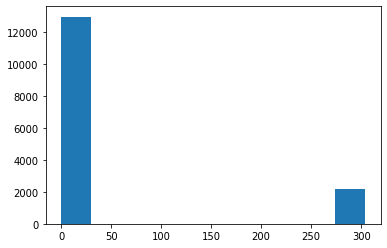

In [9]:
plt.hist(ob.flatten())

In [10]:
ob_train = ob[:100].reshape(100, -1)
ob_test = ob[:20].reshape(20, -1)
print(ob_train.shape)

(100, 126)


In [11]:
scaler_ob_train = MinMaxScaler((0,1))
ob_train_scaled = scaler_ob_train.fit_transform(ob_train)

### Test ob

In [12]:
scaler_ob_test = MinMaxScaler((0,1))
ob_test_scaled = scaler_ob_test.fit_transform(ob_test)

In [13]:
print(ob_test_scaled.shape)

(20, 126)


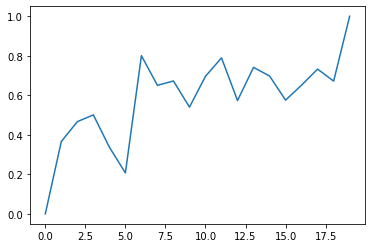

In [14]:
plt.plot(ob_test_scaled[:, 0])

In [15]:
ob_test_reshape = ob_test_scaled.reshape(20, 18, 7)
print(ob_test_reshape.shape)

(20, 18, 7)


Text(0.5, 0.98, 'Test ob at sensor 0')

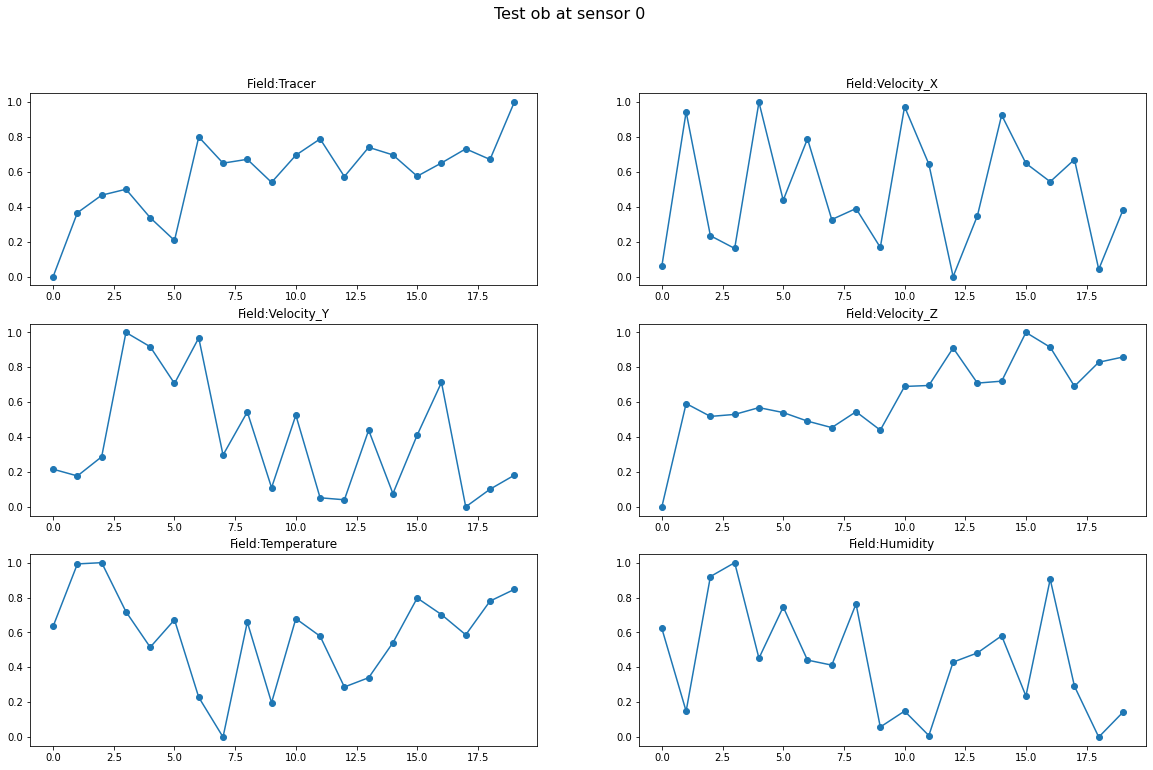

In [16]:
fields_list = ['Tracer ', 'Velocity_X', 'Velocity_Y', 'Velocity_Z', 'Temperature', 'Humidity', 'Virus1']
num_field = 6

fig, ax = plt.subplots(3,2, figsize=[20,12])
for i in range(num_field):
    ax.flatten()[i].plot(ob_test_reshape[:,i, 0], '-o')
    # ax.flatten()[i].plot(X_compressed_test[:,i*scaler], '-o')
    ax.flatten()[i].set_title("Field:{}".format(fields_list[i]))
fig.suptitle('Test ob at sensor 0', fontsize=16)

## Load Trained PredANN model

In [12]:
# Load predann model
ann, d = load_model(root_path + 'Cotrace_fixed_720_models/ann_train_n{}_e{}_s{}.h5'.format(ntimes, epochs, step)).layers

### Prediction results-Train

In [13]:
# predict all

t_start = 400
prediction_num = X_compressed.shape[0]-ntimes+1

scaler = 1
num_sample = 4

nth_node = 5

preds = []
# choose initial input
initial_input = X_compressed[t_start:t_start+ntimes-1,:]
current_input = initial_input.reshape((1, ntimes-1, ncoeffs, 1))
# current_input = tf.data.Dataset.from_tensor_slices(initial_input)
# print(current_input.shape)
for j in range(prediction_num):
    pred = ann.predict(current_input)

    preds.append(pred)
    # print(current_input[:,1:].shape)
    # print(pred.reshape((1, 1, ncoeffs, 1)).shape)

    new_input = np.concatenate((current_input[:,1:], pred.reshape((1, 1, ncoeffs, 1))), axis = 1)

    current_input = new_input
preds = np.array(preds).reshape((prediction_num, ncoeffs))
preds = np.concatenate((initial_input, preds))

print(initial_input.shape)
print(preds.shape)

2022-08-07 15:27:38.670006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202


1/1 [==============================] - 0s 16ms/step
(8, 550)
(600, 550)


Text(0.5, 0.98, 'PredANN prediction results on Training set')

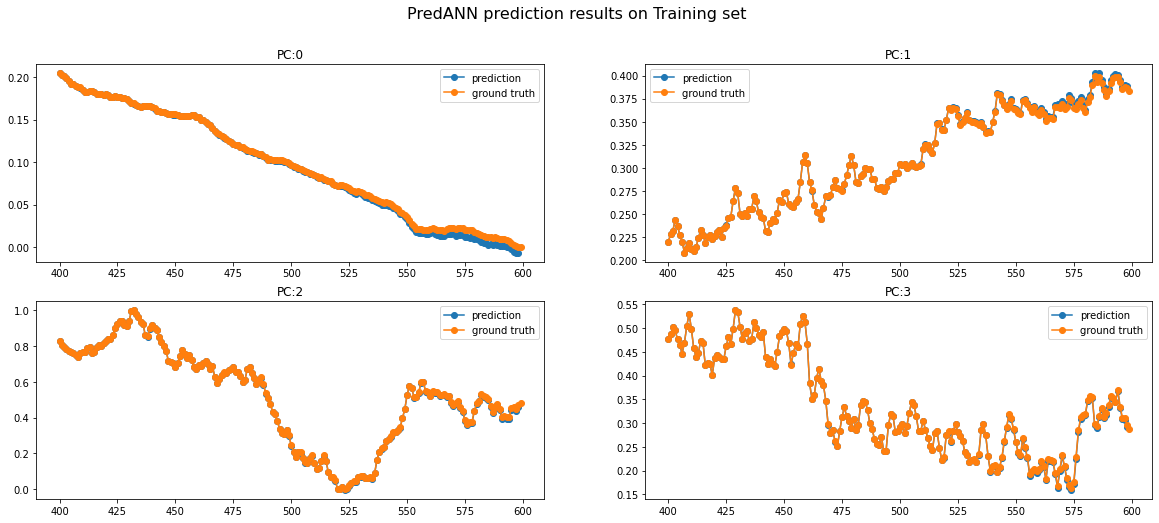

In [14]:
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(range(t_start, prediction_num+7),preds[:prediction_num-t_start+7, i*scaler], '-o')
    ax.flatten()[i].plot(range(t_start, prediction_num+8),X_compressed[t_start:,i*scaler], '-o')
    ax.flatten()[i].set_title("PC:{}".format(i))
    ax.flatten()[i].legend(['prediction', 'ground truth'])
fig.suptitle('PredANN prediction results on Training set', fontsize=16)

In [15]:
print(initial_input.shape)
print(preds.shape)
print(X_compressed.shape)

(8, 550)
(600, 550)
(600, 550)


Text(0.5, 0.98, 'PredANN prediction results on Training set')

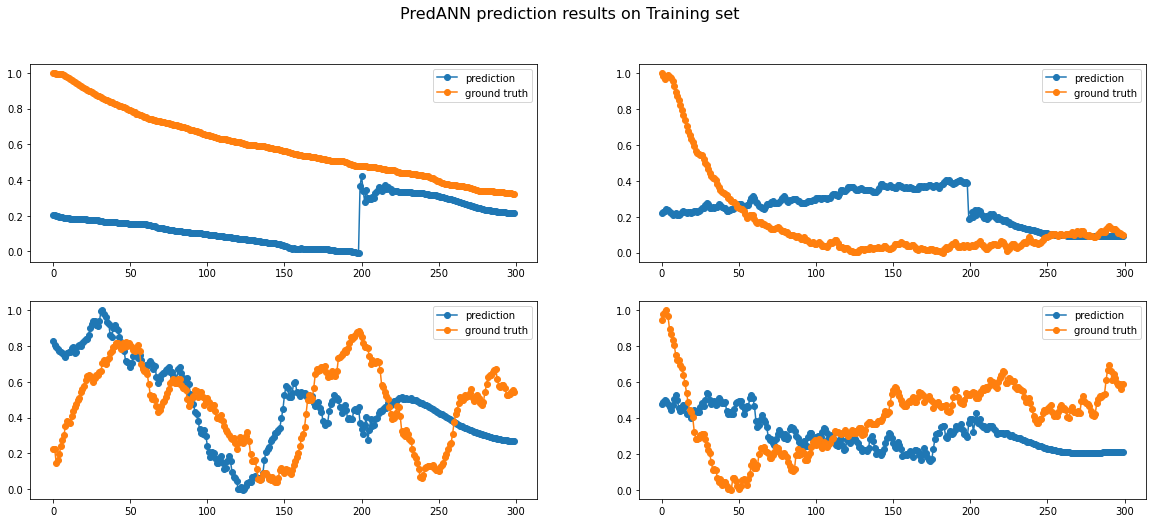

In [15]:
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:500, i*scaler], '-o')
    ax.flatten()[i].plot(preds[:300, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed[:300,i*scaler], '-o')
    ax.flatten()[i].legend(['prediction', 'ground truth'])
fig.suptitle('PredANN prediction results on Training set', fontsize=16)

Text(0.5, 0.98, 'PredANN prediction results on Training set')

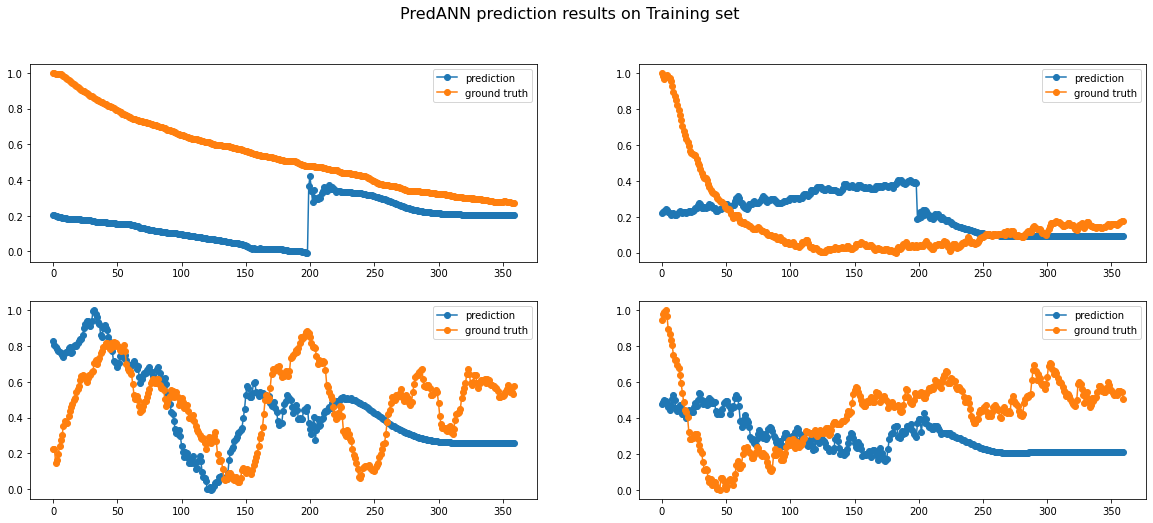

In [16]:
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:500, i*scaler], '-o')
    ax.flatten()[i].plot(preds[:360, i*scaler], '-o')
    ax.flatten()[i].plot(X_compressed[:360,i*scaler], '-o')
    ax.flatten()[i].legend(['prediction', 'ground truth'])
fig.suptitle('PredANN prediction results on Training set', fontsize=16)

### Prediction results-Test

1/1 [==============================] - 0s 16ms/step
(8, 550)
(120, 550)


Text(0.5, 0.98, 'PredANN prediction results on Test set without DA')

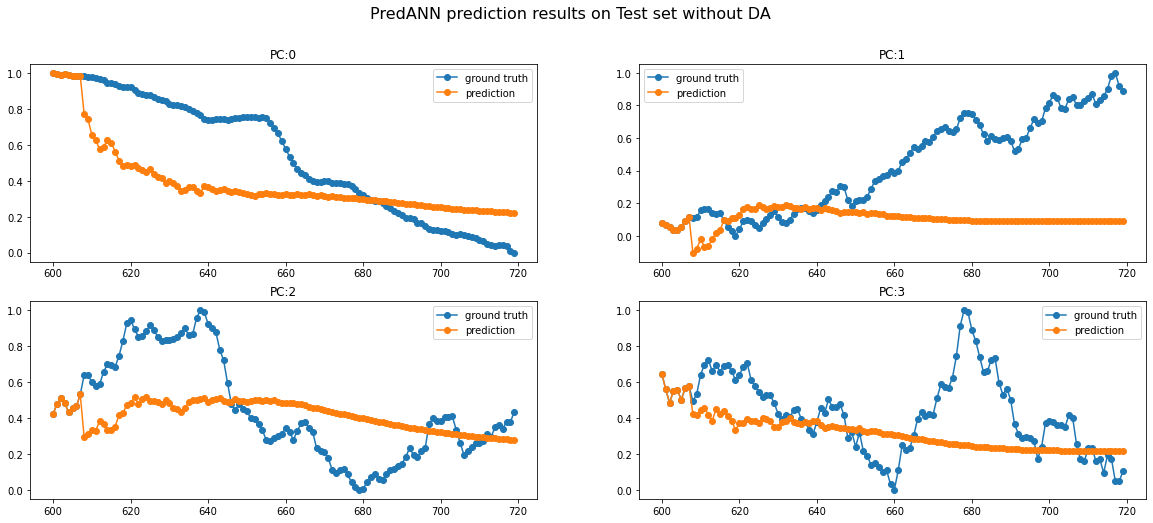

In [16]:
# predict all

t_start = 0
prediction_num = X_compressed_test.shape[0]-ntimes+1

scaler = 1
num_sample = 4

nth_node = 5

preds = []
# choose initial input
initial_input = X_compressed_test[t_start:t_start+ntimes-1,:]
current_input = initial_input.reshape((1, ntimes-1, ncoeffs, 1))
# current_input = tf.data.Dataset.from_tensor_slices(initial_input)
# print(current_input.shape)
for j in range(prediction_num):
    pred = ann.predict(current_input)

    preds.append(pred)
    # print(current_input[:,1:].shape)
    # print(pred.reshape((1, 1, ncoeffs, 1)).shape)

    new_input = np.concatenate((current_input[:,1:], pred.reshape((1, 1, ncoeffs, 1))), axis = 1)

    current_input = new_input
preds = np.array(preds).reshape((prediction_num, ncoeffs))
preds = np.concatenate((X_compressed_test[0:t_start+ntimes-1,:], preds))

print(initial_input.shape)
print(preds.shape)
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(range(600, 720), X_compressed_test[:,i*scaler], '-o')
    ax.flatten()[i].plot(range(600, 720), preds[:, i*scaler], '-o')
    ax.flatten()[i].set_title("PC:{}".format(i))
    ax.flatten()[i].legend(['ground truth', 'prediction'])
fig.suptitle('PredANN prediction results on Test set without DA', fontsize=16)

Text(0.5, 0.98, 'PredANN prediction results on Test set without DA')

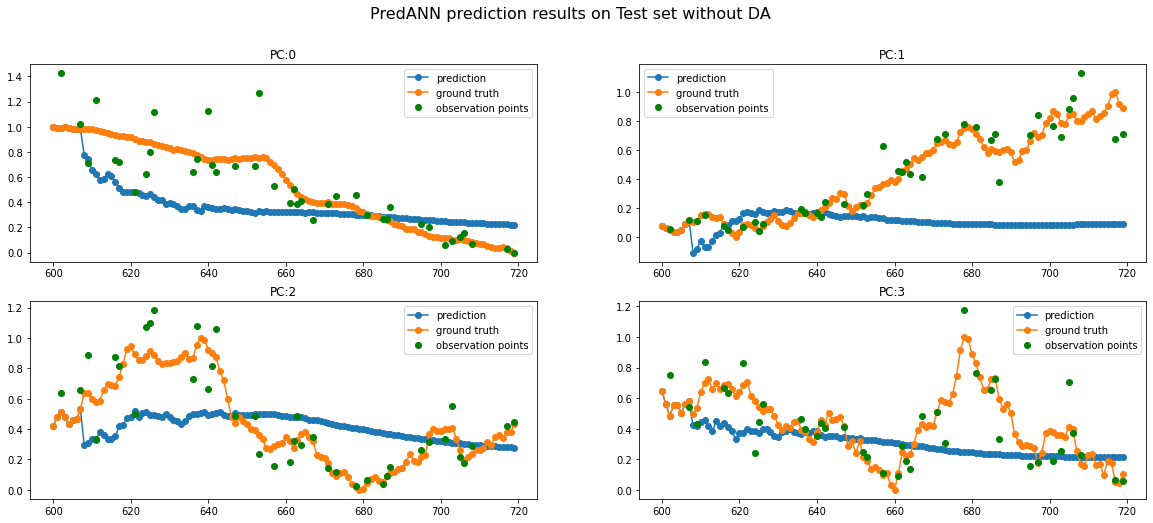

In [17]:
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    

    # ax.flatten()[i].plot(initial_input[:, i*scaler], '-o')
    ax.flatten()[i].plot(range(600, 720), preds[:, i*scaler], '-o')
    ax.flatten()[i].plot(range(600, 720), X_compressed_test[:,i*scaler], '-o')
    ax.flatten()[i].plot(obs_points[:,0]+600, obs_points[:,i*scaler+1], 'go')
    ax.flatten()[i].set_title("PC:{}".format(i))
    ax.flatten()[i].legend(['prediction','ground truth','observation points'])
fig.suptitle('PredANN prediction results on Test set without DA', fontsize=16)

#### Calculate the prediction values at 18 sensors

In [20]:
print(preds.shape)

(120, 550)


In [22]:
pred_pca_inverse = pca_compress.inverse_transform(preds)
print(pred_pca_inverse.shape)

(120, 1344420)


In [29]:
pred_fields = []
fields_list = ['Tracer ', 'Velocity_X', 'Velocity_Y', 'Velocity_Z', 'Temperature', 'Humidity', 'Virus1']
for i in range(len(fields_list)):
    field = pred_pca_inverse[:, i*nNodes:(i+1)*nNodes]
    print(field.shape)
    pred_fields.append(field)

(20, 192060)
(20, 192060)
(20, 192060)
(20, 192060)
(20, 192060)
(20, 192060)
(20, 192060)


In [30]:
pred_fields_sensors = []
for i in range(len(fields_list)):
    pred_fields_sensor = t.idw(pred_fields[i].reshape(pred_fields[i].shape[1],pred_fields[i].shape[0]))
    print(pred_fields_sensor.shape)
    pred_fields_sensors.append(pred_fields_sensor)

(18, 20)
(18, 20)
(18, 20)
(18, 20)
(18, 20)
(18, 20)
(18, 20)


In [54]:
pred_fields_sensors = np.array(pred_fields_sensors.reshape(20,7,18))
print(pred_fields_sensors.shape)

(20, 7, 18)


Text(0.5, 0.98, 'Sensor Prediction at sensor 0 (before scale back)')

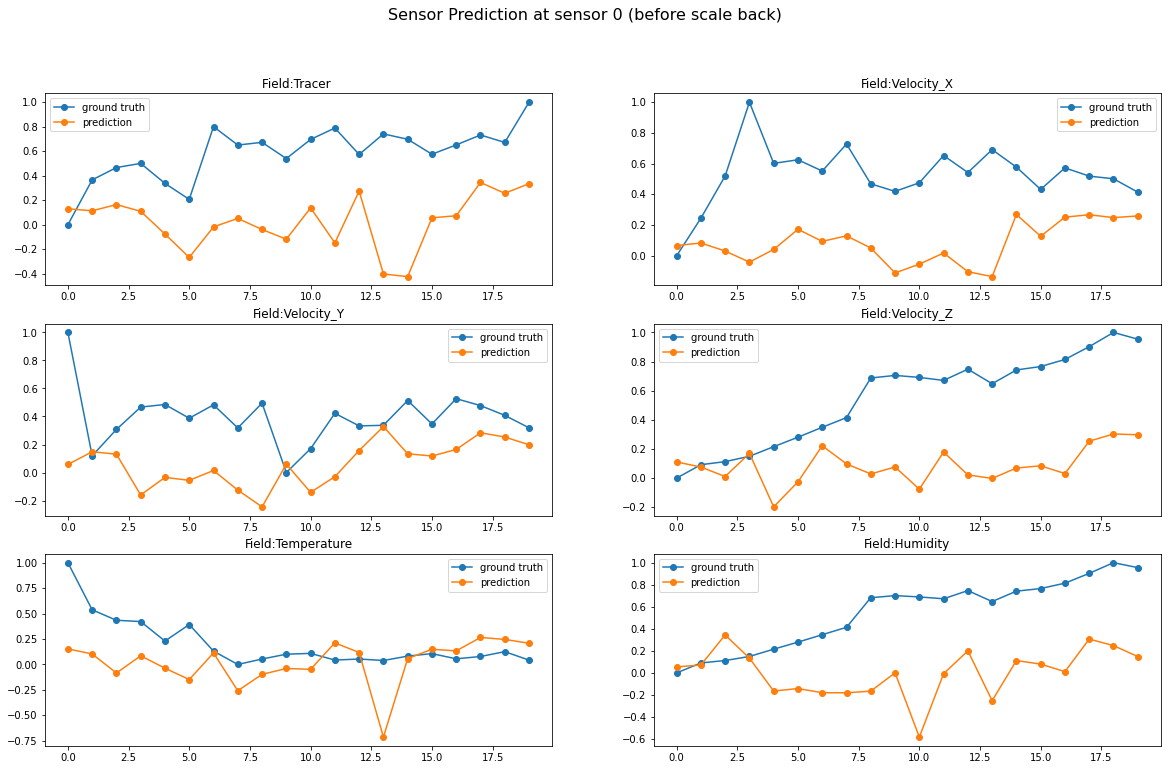

In [58]:
num_field = 6

fig, ax = plt.subplots(3,2, figsize=[20,12])
for i in range(num_field):
    # ax.flatten()[i].plot(pred_fields_sensors[i][0], '-o')
    ax.flatten()[i].plot(ob_test_reshape[:,i, 0], '-o')
    ax.flatten()[i].plot(pred_fields_sensors[:,i, 0], '-o')
    ax.flatten()[i].set_title("Field:{}".format(fields_list[i]))
    ax.flatten()[i].legend(['ground truth', 'prediction'])
fig.suptitle('Sensor Prediction at sensor 0 (before scale back)', fontsize=16)

In [59]:
sensor_difference = pred_fields_sensors - ob_test_reshape

## Back propogation

### One timestep

### Train

(1, 550)
(1, 8, 550, 1)
(1, 550)
tf.Tensor([0.9841356], shape=(1,), dtype=float32)
tf.Tensor([0.9840854], shape=(1,), dtype=float32)


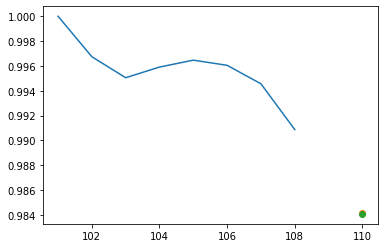

In [17]:
n = 0
real_coding = X_train_4d[n][-1].reshape(1,-1)
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

latent_values = X_train_4d[n][:-1].reshape(-1, ntimes-1, ncoeffs,1)
print(latent_values.shape)

gen_output = ann(latent_values)
print(gen_output.shape)

print(real_coding[:, 0])
print(gen_output[:, 0])

plt.plot(range(101, 109), latent_values.reshape(8,ncoeffs)[:, 0])
plt.plot(110, real_coding[:, 0], '-o' )
plt.plot(110, gen_output[:, 0], '-o' )
plt.show()

### Test

(1, 550)
(1, 8, 550, 1)
(1, 550)
tf.Tensor([0.9813226], shape=(1,), dtype=float32)
tf.Tensor([0.916893], shape=(1,), dtype=float32)


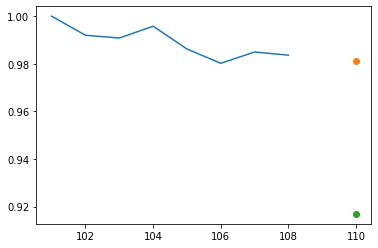

In [18]:
n = 0
real_coding = X_test_4d[n][-1].reshape(1,-1)
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

latent_values = X_test_4d[n][:-1].reshape(-1, ntimes-1, ncoeffs,1)
print(latent_values.shape)

gen_output = ann(latent_values)
print(gen_output.shape)

print(real_coding[:, 0])
print(gen_output[:, 0])

plt.plot(range(101, 109), latent_values.reshape(8,ncoeffs)[:, 0])
plt.plot(110, real_coding[:, 0], '-o' )
plt.plot(110, gen_output[:, 0], '-o' )
plt.show()

(18, 7)


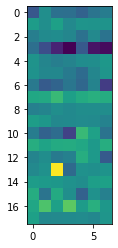

In [21]:
gen_output_nodes = pca_compress.inverse_transform(gen_output)

gen_output_sensors = t.idw(gen_output_nodes.reshape(nNodes,-1))
print(gen_output_sensors.shape)
plt.imshow(gen_output_sensors)

(18, 7)


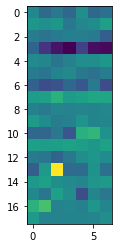

In [28]:
gen_output_nodes = pca_compress.inverse_transform(gen_output)

gen_output_sensors = t.idw(gen_output_nodes.reshape(nNodes,-1))
print(gen_output_sensors.shape)
plt.imshow(gen_output_sensors)

In [29]:
data_range_ = tf.constant(scaler_minmax_test.data_range_, dtype=tf.float32)
# print(data_range_)
data_min_ = tf.constant(scaler_minmax_test.data_min_, dtype=tf.float32)
components_ = tf.constant(pca_compress.components_, dtype=tf.float32)
pca_mean_ = tf.constant(pca_compress.mean_, dtype=tf.float32)

Distance_selected = np.load(root_path + 'idw_paras/Distance_selected.npy')
Index = tf.reshape(tf.constant(np.load(root_path + 'idw_paras/Index.npy')), [18*4]).numpy().tolist()
print(Distance_selected.shape)
print(Index)

(18, 4)
[130728, 128933, 129455, 129486, 22326, 23409, 24157, 24188, 69833, 69564, 71099, 69799, 127088, 128887, 128934, 128922, 24075, 24230, 21796, 24234, 71088, 69794, 71114, 69821, 128729, 128905, 128059, 128751, 20635, 21383, 20657, 20038, 156387, 156447, 157179, 156576, 97146, 96578, 97171, 96605, 25871, 25568, 25592, 24811, 147978, 147923, 150650, 150746, 91770, 91479, 91305, 91758, 38520, 26872, 42206, 38514, 147665, 148845, 147679, 147686, 95073, 91976, 91437, 91721, 45086, 45055, 45027, 39478, 149264, 148974, 148542, 149032]


In [27]:
print(Distance_selected[0])

[0.06033493 0.07680884 0.07789891 0.11263914]


In [233]:
print(ob_test_reshape.shape)
print(gen_output.shape)

(20, 18, 7)
(1, 90)


In [311]:
# codings_size = ncoeffs
def obs_sse_loss(obs_data, gen_output): 
    # -- Observed data --
    #   
    # # scaler.inverse_transform
    gen_output_scaled = ((tf.reshape(gen_output, [-1, ncoeffs])+1)/2)*data_range_ + data_min_
    print( gen_output_scaled.shape)  
    # pca_compress.inverse_transform
    X_generated = gen_output[:,:ncoeffs]@components_+pca_mean_
    print(X_generated.shape)



    

    values = tf.cast(tf.split(X_generated, 7, axis=1), dtype='float64')
    weights = 1.0 / Distance_selected
    weights_sum = tf.reshape(tf.reduce_sum(weights, axis=1),[1, 18])
    weights_sum_repeat = tf.reshape(tf.repeat(weights_sum, 4), [18, 4])
    weights = weights/weights_sum_repeat
    weights_transpose = tf.reshape(weights, [4, 18])
    idw_result = []
    for i in range(7):
        v = tf.reshape(tf.gather(tf.reshape(values[i],[nNodes]),indices=Index), [18, 4])
        rs = []
        for j in range(18):
            w = tf.reshape(weights_transpose[:, j], [1,4])
            vv = tf.reshape(v[j,:], [4,1])
            r = tf.tensordot(w, vv, axes=1).numpy()
            rs.append(r)
        idw_result.append(rs)

    gen_output_sensors = tf.cast(tf.reshape(tf.constant(idw_result), [18, 7]), dtype='float32')
    # print(idw_result.shape)

    # gen_output_sensors = idw_tf(tf.reshape(X_generated, [nNodes, -1]))
    # print(gen_output_sensors.dtype)
    # print(gen_output_sensors.shape)
    
    # obs_loss = tf.reduce_mean(tf.math.squared_difference(gen_output_sensors, obs_data))
    obs_loss = tf.reduce_mean(tf.math.squared_difference(X_generated, X_generated**2))
    # obs_loss = tf.reduce_mean(tf.math.squared_difference(obs_data**2, obs_data))
        
    return obs_loss

In [312]:
obs_sse_loss(ob_test_reshape[0],gen_output)

(1, 90)
(1, 1344420)


<tf.Tensor: shape=(), dtype=float32, numpy=0.11905333>

In [23]:
optimizer = tf.keras.optimizers.Adam(1e-2)
mse = tf.keras.losses.MeanSquaredError()

def mse_loss(inp, outp):
    return mse(inp, outp)

In [24]:
# @tf.function
def opt_step(initial_condition, real_coding):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(initial_condition)
        gen_output = ann(initial_condition)

        # gen_output = pca_compress.inverse_transform(gen_output)
        # gen_output = t.idw(gen_output.reshape(nNodes,-1))
        # gen_output = tf.constant(gen_output)
        # gen_output = tf.cast(gen_output, dtype=tf.float32)
        # gen_output = tf.Variable(gen_output)

        # real_coding = ob_test_reshape[8]
        # real_coding = tf.constant(real_coding)
        # real_coding = tf.cast(real_coding, dtype=tf.float32)

        loss = mse_loss(real_coding, gen_output)
        print(loss)


    gradient = tape.gradient(loss, initial_condition) 
    # print(gradient) 
    optimizer.apply_gradients(zip([gradient], [initial_condition]))  
    
    return loss

In [25]:
latent_values = tf.constant(latent_values)
latent_values = tf.cast(latent_values, dtype=tf.float32)
latent_values = tf.Variable(latent_values, name="initial_condition")
print(latent_values.name)
print(real_coding.shape)

initial_condition:0
(1, 550)


In [26]:
opt_step(latent_values, real_coding)

tf.Tensor(0.047741532, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.047741532>

In [27]:
def optimize_coding(latent_values, real_coding):
    # latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)  
    # latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(200):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return latent_values, loss[-1]  

tf.Tensor(0.042282302, shape=(), dtype=float32)
tf.Tensor(0.037578385, shape=(), dtype=float32)
tf.Tensor(0.033453267, shape=(), dtype=float32)
tf.Tensor(0.029743735, shape=(), dtype=float32)
tf.Tensor(0.026374381, shape=(), dtype=float32)
tf.Tensor(0.023298299, shape=(), dtype=float32)
tf.Tensor(0.02049468, shape=(), dtype=float32)
tf.Tensor(0.01795943, shape=(), dtype=float32)
tf.Tensor(0.015674401, shape=(), dtype=float32)
tf.Tensor(0.013632864, shape=(), dtype=float32)
tf.Tensor(0.011823785, shape=(), dtype=float32)
tf.Tensor(0.010224645, shape=(), dtype=float32)
tf.Tensor(0.00881278, shape=(), dtype=float32)
tf.Tensor(0.007572655, shape=(), dtype=float32)
tf.Tensor(0.0064880624, shape=(), dtype=float32)
tf.Tensor(0.0055371756, shape=(), dtype=float32)
tf.Tensor(0.0047078053, shape=(), dtype=float32)
tf.Tensor(0.003985291, shape=(), dtype=float32)
tf.Tensor(0.003362358, shape=(), dtype=float32)
tf.Tensor(0.002831128, shape=(), dtype=float32)
tf.Tensor(0.002378776, shape=(), dtype=f

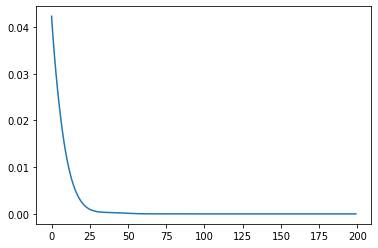

In [28]:
start = time.time()
list_latent_values = []
list_loss = []
for _ in range(1):
    latent_values, loss = optimize_coding(latent_values, real_coding)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values_new = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end=' - ')
print ('{:.0f}s'.format( time.time()-start))
print(list_loss)

# print('Loss: ', mse_loss(ann(latent_values), real_coding).numpy())
# print(latent_values)

In [29]:
print(latent_values_new.shape)

(1, 8, 550, 1)


In [30]:
gen_output_new = ann(latent_values_new)
print(gen_output_new.shape)

(1, 550)


tf.Tensor([0.9813226], shape=(1,), dtype=float32)
tf.Tensor([0.916893], shape=(1,), dtype=float32)
tf.Tensor([0.9813261], shape=(1,), dtype=float32)


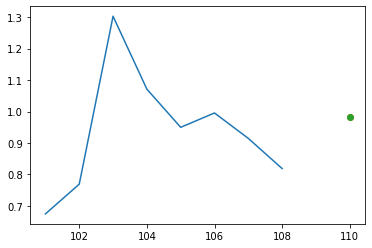

In [32]:
plt.plot(range(101, 109), latent_values.numpy().reshape(8,ncoeffs)[:, 0])
plt.plot(110, real_coding[:, 0], '-o' )
# plt.plot(110, gen_output[:, 0], '-o' )
# plt.plot(range(101, 109), (latent_values_new.numpy()).reshape(8,ncoeffs)[:, 0])
plt.plot(110, gen_output_new[:, 0], '-o' )

print(real_coding[:,0])
print(gen_output[:,0])
print(gen_output_new[:,0])

plt.show()

### Implement with observation form data

In [21]:
# calculate the loss between real and prediction of POD coiffecients
def mse_loss(inp, outp):
    return tf.reduce_mean(tf.math.squared_difference(inp, outp))

def optimize_coding(initial_condition, real_coding, epochs=200):
    
    optimizer = tf.keras.optimizers.Adam(1e-2)
    
    @tf.function
    def opt_step(initial_condition, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(initial_condition)
            gen_output = ann(initial_condition, training=False)

            
             
            loss = mse_loss(real_coding, gen_output)   

        gradient = tape.gradient(loss, initial_condition)  
        optimizer.apply_gradients(zip([gradient], [initial_condition]))  

        return loss
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(initial_condition, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return initial_condition, loss[-1]  #returns the optimized input that generates the desired output

In [22]:
print(obs_times)

[602. 607. 609. 611. 616. 617. 621. 624. 625. 626. 636. 637. 640. 641.
 642. 647. 652. 653. 657. 661. 662. 663. 664. 667. 671. 673. 678. 681.
 685. 686. 687. 695. 697. 701. 703. 705. 706. 708. 717. 719.]


Loss iteration 1: 4.658995e-05 - (1, 8, 550, 1)
2s
Loss iteration 2: 0.0001090302 - (1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
Loss iteration 4: 0.00010918938 - (1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
Loss iteration 9: 0.00010551095 - (1, 8, 550, 1)
0s
Loss iteration 10: 6.542244e-05 - (1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
Loss iteration 14: 0.00011300377 - (1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
Loss iteration 17: 9.556701e-05 - (1, 8, 550, 1)
0s
Loss iteration 18: 3.7002686e-05 - (1, 8, 550, 1)
0s
Loss iteration 19: 5.0189195e-05 - (1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
Loss iteration 29: 9.0654095e-05 - (1, 8, 550, 1)
0s
Loss iteration 30: 6.484167e-05 - (1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
(1, 8, 550, 1)
0s
Loss iteration 33: 9.1461894e-05 - (1, 8, 550, 1

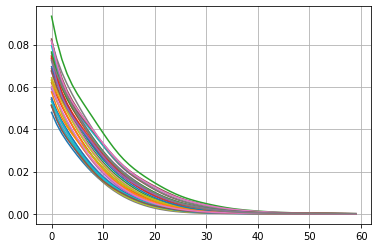

In [23]:
n = 0
X_predict_4dVar = []
X_real = []
t = X_test_4d[n][-1][0][0] + 600
latent_values = X_test_4d[n][:-1][:,1:].reshape(-1, ntimes-1, ncoeffs,1)
latent_values = tf.Variable(latent_values)
real_coding = X_test_4d[n][-1][1:].reshape(1,-1)
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

prediction_num = X_compressed_test.shape[0]-ntimes

for i in range(X_compressed_test.shape[0]-ntimes): #range(2000,len(X_train_concat)-1):
    # print(t)
    start = time.time()
    if t in obs_times:
        latent_values, loss = optimize_coding(latent_values, real_coding, epochs=60)
        print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
        
    # gen_predict = ann(latent_values).numpy().flatten()
    gen_predict = ann(latent_values)
    X_predict_4dVar.append(gen_predict)
    # gen_predict[-2:] = R0s_run

    X_real.append(real_coding)

    t = X_test_4d[i][-1][0][0] + 600
    latent_values = (np.vstack((latent_values[0, 1:, :, 0], gen_predict))).reshape(1, 8, ncoeffs, 1)
    latent_values = tf.Variable(latent_values)
    print(latent_values.shape)

    # real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ncoeffs:]
    real_coding = X_test_4d[i][-1][1:].reshape(1,-1)
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
    
X_predict_4dVar = np.array(X_predict_4dVar)
print(X_predict_4dVar.shape)
X_real = np.array(X_real)
print(X_real.shape)
plt.grid()

Text(0.5, 0.98, 'PredANN prediction results on Test set with DA')

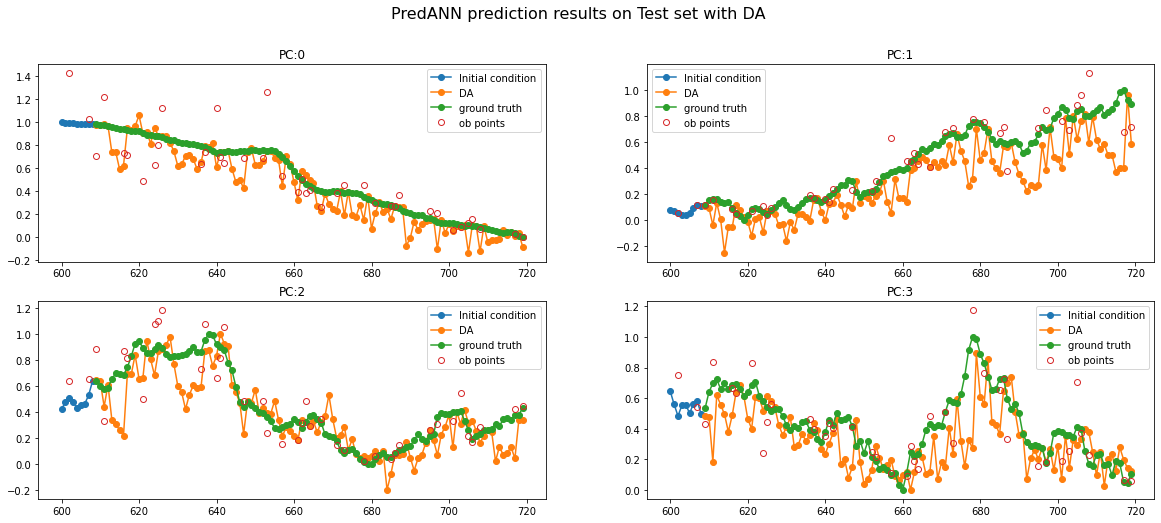

In [24]:
num_sample = 4
scaler = 1
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    
    ax.flatten()[i].plot(range(600, 609), X_test_4d[n][:,1:,:][:, i*scaler], '-o')
    # ax.flatten()[i].plot(range(609, 720), preds[9:, i*scaler], '-o')
    ax.flatten()[i].plot(range(609, 720), X_predict_4dVar.reshape(prediction_num,ncoeffs)[:, i*scaler], '-o', )
    ax.flatten()[i].plot(range(609, 720), X_compressed_test[9:,i*scaler], '-o')
    ax.flatten()[i].plot(obs_points[:,0]+600, obs_points[:,i*scaler+1], 'o', markerfacecolor='none')
    ax.flatten()[i].set_title("PC:{}".format(i))
    ax.flatten()[i].legend(['Initial condition', 'DA', 'ground truth', 'ob points'])   #'Prediction without DA'
fig.suptitle('PredANN prediction results on Test set with DA', fontsize=16)

### Implement 4D-Var-Multiple timesteps

In [20]:
# calculate the loss between real and prediction of POD coiffecients
def mse_loss(inp, outp):
    return tf.reduce_mean(tf.math.squared_difference(inp, outp))

def optimize_coding(initial_condition, real_coding, epochs=200):
    
    optimizer = tf.keras.optimizers.Adam(1e-2)
    
    @tf.function
    def opt_step(initial_condition, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(initial_condition)
            gen_output = ann(initial_condition, training=False)

            
             
            loss = mse_loss(real_coding, gen_output)   

        gradient = tape.gradient(loss, initial_condition)  
        optimizer.apply_gradients(zip([gradient], [initial_condition]))  

        return loss
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(initial_condition, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return initial_condition, loss[-1]  #returns the optimized input that generates the desired output

In [64]:
n = 0
real_coding = X_test_4d[n][-1].reshape(1,-1)
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

(1, 550)


Initial point losses: [2.4472268e-11, 2.4439527e-11, 2.4469144e-11, 2.4473083e-11, 2.4453085e-11, 2.4454438e-11, 2.4505639e-11, 2.4457129e-11, 2.4457174e-11, 2.4476811e-11]
1
(550,)
(1, 550)


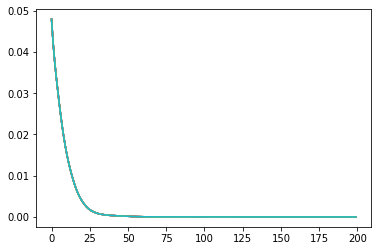

In [65]:
list_latent_values = []
list_loss = []
for _ in range(10):
    # latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)
    latent_values = X_test_4d[n][:-1].reshape(-1, ntimes-1, ncoeffs,1)  
    latent_values = tf.Variable(latent_values)     
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=200)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end='')
print(list_loss)
        
X_predict = list(ann(latent_values).numpy().reshape(-1,ncoeffs))
print(len(X_predict))
gen_predict = X_predict[-1]
print(gen_predict.shape)
# gen_predict[-2:] = R0s_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ncoeffs:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

Loss iteration 1: 4.65899e-05 - (1, 8, 550, 1)
0s
Loss iteration 2: 0.00010903124 - (1, 8, 550, 1)
0s
Loss iteration 3: 6.997246e-05 - (1, 8, 550, 1)
0s
Loss iteration 4: 7.898157e-05 - (1, 8, 550, 1)
0s
Loss iteration 5: 8.155822e-05 - (1, 8, 550, 1)
0s
Loss iteration 6: 5.9724633e-05 - (1, 8, 550, 1)
0s
Loss iteration 7: 5.5835928e-05 - (1, 8, 550, 1)
0s
Loss iteration 8: 6.297968e-05 - (1, 8, 550, 1)
0s
Loss iteration 9: 5.3157055e-05 - (1, 8, 550, 1)
0s
Loss iteration 10: 8.3520164e-05 - (1, 8, 550, 1)
0s
Loss iteration 11: 5.082075e-05 - (1, 8, 550, 1)
0s
Loss iteration 12: 7.77813e-05 - (1, 8, 550, 1)
0s
Loss iteration 13: 9.439162e-05 - (1, 8, 550, 1)
0s
Loss iteration 14: 7.080154e-05 - (1, 8, 550, 1)
0s
Loss iteration 15: 6.6618624e-05 - (1, 8, 550, 1)
0s
Loss iteration 16: 7.242559e-05 - (1, 8, 550, 1)
0s
Loss iteration 17: 6.681666e-05 - (1, 8, 550, 1)
0s
Loss iteration 18: 9.042653e-05 - (1, 8, 550, 1)
0s
Loss iteration 19: 6.6490065e-05 - (1, 8, 550, 1)
0s
Loss iteration 2

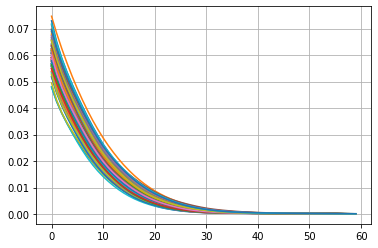

In [66]:
n = 0
X_predict_4dVar = []
X_real = []
latent_values = X_test_4d[n][:-1].reshape(-1, ntimes-1, ncoeffs,1)
latent_values = tf.Variable(latent_values)
real_coding = X_test_4d[n][-1].reshape(1,-1)
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

prediction_num = X_compressed_test.shape[0]-ntimes

for i in range(X_compressed_test.shape[0]-ntimes): #range(2000,len(X_train_concat)-1):
    start = time.time()
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=60)
    print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
        
    # gen_predict = ann(latent_values).numpy().flatten()
    gen_predict = ann(latent_values)
    X_predict_4dVar.append(gen_predict)
    # gen_predict[-2:] = R0s_run

    X_real.append(real_coding)

    latent_values = (np.vstack((latent_values[0, 1:, :, 0], gen_predict))).reshape(1, 8, ncoeffs, 1)
    latent_values = tf.Variable(latent_values)
    print(latent_values.shape)

    # real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ncoeffs:]
    real_coding = X_test_4d[i][-1].reshape(1,-1)
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
    
X_predict_4dVar = np.array(X_predict_4dVar)
print(X_predict_4dVar.shape)
X_real = np.array(X_real)
print(X_real.shape)
plt.grid()

In [67]:
print(preds[9:,:].shape)
print(X_predict_4dVar.shape)
print(X_compressed_test.shape)

(111, 550)
(111, 1, 550)
(120, 550)


Text(0.5, 0.98, 'PredANN prediction results on Test set with DA')

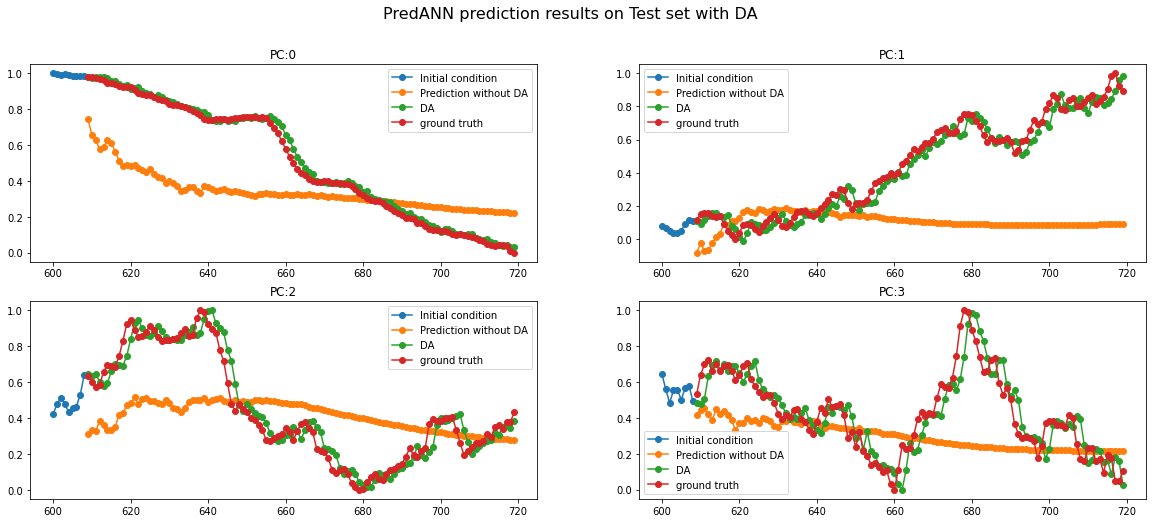

In [68]:
fig, ax = plt.subplots(2,2, figsize=[20,8])
for i in range(num_sample):
    
    ax.flatten()[i].plot(range(600, 609), X_test_4d[n][:][:, i*scaler], '-o')
    ax.flatten()[i].plot(range(609, 720), preds[9:, i*scaler], '-o')
    ax.flatten()[i].plot(range(609, 720), X_predict_4dVar.reshape(prediction_num,ncoeffs)[:, i*scaler], '-o', )
    ax.flatten()[i].plot(range(609, 720), X_compressed_test[9:,i*scaler], '-o')
    ax.flatten()[i].set_title("PC:{}".format(i))
    ax.flatten()[i].legend(['Initial condition', 'Prediction without DA', 'DA', 'ground truth'])
fig.suptitle('PredANN prediction results on Test set with DA', fontsize=16)

### Applying relaxation

In [25]:
# calculate the loss between real and prediction of POD coiffecients
def mse_loss(inp, outp):
    return tf.reduce_mean(tf.math.squared_difference(inp, outp))

def optimize_coding(initial_condition, real_coding, epochs=200):
    
    optimizer = tf.keras.optimizers.Adam(1e-2)
    
    @tf.function
    def opt_step(initial_condition, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(initial_condition)
            gen_output = ann(initial_condition, training=False)
   
            loss = mse_loss(real_coding, gen_output)   

        gradient = tape.gradient(loss, initial_condition)  
        optimizer.apply_gradients(zip([gradient], [initial_condition]))  

        return loss
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(initial_condition, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return initial_condition, loss[-1]  #returns the optimized input that generates the desired output


Iteration: 0
Loss iteration 1: 4.658995e-05 - 0s
Loss iteration 2: 0.0001090302 - 0s
0s
Loss iteration 4: 0.00010918938 - 0s
0s
0s
0s
0s
Loss iteration 9: 0.00010551095 - 0s
Loss iteration 10: 6.542244e-05 - 0s
0s
0s
0s
Loss iteration 14: 0.00011300377 - 0s
0s
0s
Loss iteration 17: 9.556701e-05 - 0s
Loss iteration 18: 3.7002686e-05 - 0s
Loss iteration 19: 5.0189195e-05 - 0s
0s
0s
0s
0s
0s
0s
0s
0s
0s
Loss iteration 29: 9.0654095e-05 - 0s
Loss iteration 30: 6.484167e-05 - 0s
0s
0s
Loss iteration 33: 9.1461894e-05 - 0s
Loss iteration 34: 7.109993e-05 - 0s
Loss iteration 35: 8.060971e-05 - 0s
0s
0s
0s
0s
Loss iteration 40: 9.838312e-05 - 0s
0s
0s
0s
0s
Loss iteration 45: 0.00010849529 - 0s
Loss iteration 46: 7.407313e-05 - 0s
0s
0s
0s
Loss iteration 50: 0.00017088001 - 0s
0s
0s
0s
Loss iteration 54: 8.825483e-05 - 0s
Loss iteration 55: 5.53921e-05 - 0s
Loss iteration 56: 7.1775e-05 - 0s
Loss iteration 57: 8.061876e-05 - 0s
0s
0s
Loss iteration 60: 0.00016991397 - 0s
0s
0s
0s
Loss iterati

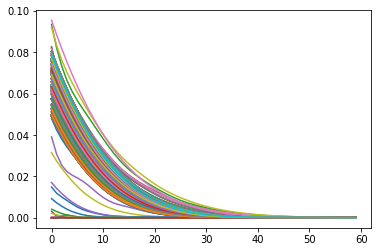

In [28]:
np.random.seed(0)
tf.random.set_seed(0)

list_X_predict_forward = []
list_relax = []

n = 0
X_predict_4dVar = []
X_real = []

forward_loss = []
relax = 1.0
for j in range(100):   
    print(f'\nIteration: {j}')
    X_predict_4dVar = []
    X_real = []
    latent_values_forward = []
    loss_obs = 0

    if j == 0: # If the first forward march
        # For the first forward march
        t = X_test_4d[n][-1][0][0] + 600
        latent_values = X_test_4d[n][:-1][:,1:].reshape(-1, ntimes-1, ncoeffs,1)
        latent_values = tf.Variable(latent_values)
        real_coding = X_test_4d[n][-1][1:].reshape(1,-1)
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)

        prediction_num = X_compressed_test.shape[0]-ntimes

        latent_values_forward.append(latent_values.value())

        for i in range(X_compressed_test.shape[0]-ntimes): #range(2000,len(X_train_concat)-1):
            # print(t)
            start = time.time()
            if t in obs_times:
                latent_values, loss = optimize_coding(latent_values, real_coding, epochs=60)
                print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
                latent_values_forward[-1] = latent_values.value()
                loss_obs += loss
                
            # gen_predict = ann(latent_values).numpy().flatten()
            gen_predict = ann(latent_values)
            X_predict_4dVar.append(gen_predict)
            # gen_predict[-2:] = R0s_run

            X_real.append(real_coding)

            t = X_test_4d[i][-1][0][0] + 600
            latent_values = (np.vstack((latent_values[0, 1:, :, 0], gen_predict))).reshape(1, 8, ncoeffs, 1)
            latent_values = tf.Variable(latent_values)
            latent_values_forward.append(latent_values.value())


            # real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ncoeffs:]
            real_coding = X_test_4d[i][-1][1:].reshape(1,-1)
            real_coding = tf.constant(real_coding)
            real_coding = tf.cast(real_coding, dtype=tf.float32)
            print ('{:.0f}s'.format( time.time()-start))
            
    else: # If not the first forward march
        t = X_test_4d[n][-1][0][0] + 600
        # latent_values = X_test_4d[n][:-1][:,1:].reshape(-1, ntimes-1, ncoeffs,1)
        # latent_values = tf.Variable(latent_values)
        latent_values = tf.Variable((1-relax)*latent_values_forward_old[0] + relax*latent_values.value())
        real_coding = X_test_4d[n][-1][1:].reshape(1,-1)
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)

        prediction_num = X_compressed_test.shape[0]-ntimes

        latent_values_forward.append(latent_values.value())

        for i in range(X_compressed_test.shape[0]-ntimes): #range(2000,len(X_train_concat)-1):
            # print(t)
            start = time.time()
            if t in obs_times:
                latent_values, loss = optimize_coding(latent_values, real_coding, epochs=60)
                print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
                latent_values_forward[-1] = latent_values.value()
                loss_obs += loss
                
            # gen_predict = ann(latent_values).numpy().flatten()
            gen_predict = ann(latent_values)
            X_predict_4dVar.append(gen_predict)
            # gen_predict[-2:] = R0s_run

            X_real.append(real_coding)

            t = X_test_4d[i][-1][0][0] + 600
            # latent_values = (np.vstack((latent_values[0, 1:, :, 0], gen_predict))).reshape(1, 8, ncoeffs, 1)
            # latent_values = tf.Variable(latent_values)
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[i] + relax*latent_values.value())
            latent_values_forward.append(latent_values.value())


            # real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,ncoeffs:]
            real_coding = X_test_4d[i][-1][1:].reshape(1,-1)
            real_coding = tf.constant(real_coding)
            real_coding = tf.cast(real_coding, dtype=tf.float32)
            print ('{:.0f}s'.format( time.time()-start))

    # Save relaxation
    list_relax.append(relax)
    
    # Update relaxation
    epison = 0
    print(f'Loss obs: {loss_obs}')
    if j == 0:
        loss_obs_old = loss_obs        
        latent_values_forward_old = latent_values_forward.copy()
        X_predict_4dVar = np.array(X_predict_4dVar)
        print(X_predict_4dVar.shape)
        X_real = np.array(X_real)
        print(X_real.shape)
        plt.grid()
    else:
        print(f'Loss obs old: {loss_obs_old}')
        print(f'Relax old: {relax}, new ', end='')
        if (loss_obs - loss_obs_old) < epison:
            loss_obs_old = loss_obs
            latent_values_forward_old = latent_values_forward.copy()
            relax *= 1.5
            if relax > 1.0: 
                relax = 1.0              
        else:
            relax *= 0.5
            if relax < 0.01: 
                print(relax)
                print('Converged!')
                # # plot loss functions
                # fig, ax = plt.subplots(1,1, figsize=[8,4])
                # ax.plot(np.arange(2,len(forward_loss)), forward_loss[2:])
                # ax.set_title('Forward loss')
                # #ax.set_yscale('log')
                # #ax.set_ylim([0,20000])
                # plt.grid()
                # plt.legend(['Total loss','POD loss','R0s loss','Obs loss'])
                X_predict_4dVar = np.array(X_predict_4dVar)
                print(X_predict_4dVar.shape)
                X_real = np.array(X_real)
                print(X_real.shape)
                plt.grid()
    
                break
            latent_values_forward = latent_values_forward_old.copy()
        print(relax)

Text(0.5, 0.98, 'PredANN prediction results on Test set with DA after applying relaxation')

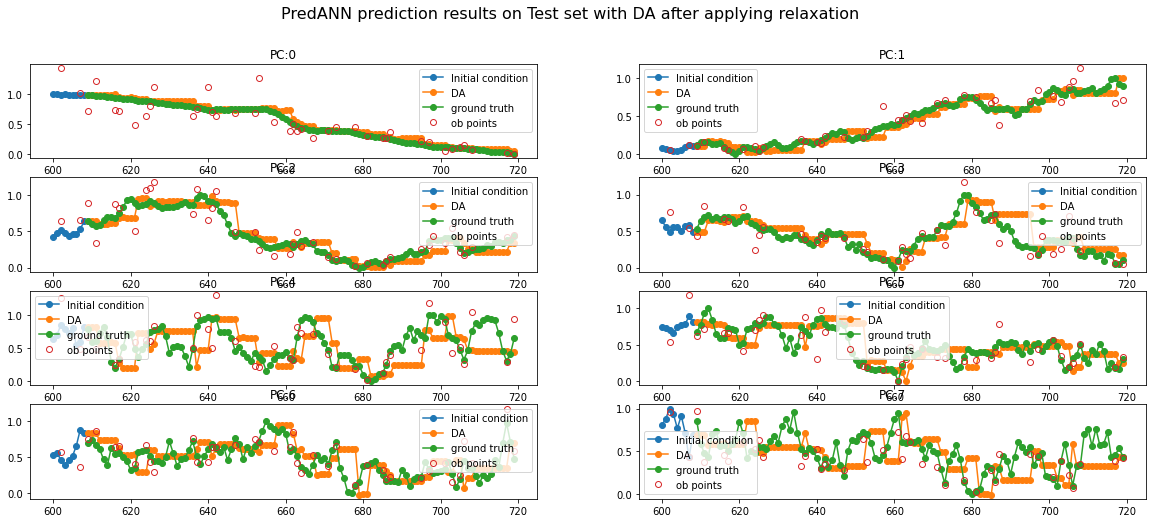

In [32]:
num_sample = 8
scaler = 1
fig, ax = plt.subplots(4,2, figsize=[20,8])
for i in range(num_sample):
    
    ax.flatten()[i].plot(range(600, 609), X_test_4d[n][:,1:,:][:, i*scaler], '-o')
    # ax.flatten()[i].plot(range(609, 720), preds[9:, i*scaler], '-o')
    ax.flatten()[i].plot(range(609, 720), X_predict_4dVar.reshape(prediction_num,ncoeffs)[:, i*scaler], '-o', )
    ax.flatten()[i].plot(range(609, 720), X_compressed_test[9:,i*scaler], '-o')
    ax.flatten()[i].plot(obs_points[:,0]+600, obs_points[:,i*scaler+1], 'o', markerfacecolor='none')
    ax.flatten()[i].set_title("PC:{}".format(i))
    ax.flatten()[i].legend(['Initial condition', 'DA', 'ground truth', 'ob points'])   #'Prediction without DA'
fig.suptitle('PredANN prediction results on Test set with DA after applying relaxation', fontsize=16)

In [59]:
# save predictions
np.save(root_path + 'Cotrace_fixed_720_npys/Predictions/Pred_ann_4dVar_test.npy', X_predict_4dVar)